  # Test of hierarchical classification (model 2)
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint as sp_randint
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from collections import Counter

  ### Definition of names for plots and files

In [2]:
morethan5 = False

extragalactic = False
galactic = False

date = '20191119'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v4/dfcrossmatches_prioritized_v4_withYSO_fromSimbad.csv'
#detections_file = '../alerce_trainingset/training_set_v3/detections.pkl'
#features_file = '../alerce_trainingset/training_set_v3/features.pkl'
features_file = '../ZTF_data/features20191119_withWISE.csv'
#features_file = '../ZTF_data/features_20191017_filtered.pkl'
#non_detections_file = '../alerce_trainingset/training_set_v3/training_non_det_v3.h5'

class_output = '../ZTF_classifications/classification_unlabelled_set_withWISE_RSCVn_periodic_20191119.csv'

#where the RF models are saved
if morethan5:
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_morethan5gr_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_morethan5gr_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_morethan5gr_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_morethan5gr_'+date

else: 
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_'+date

#confusion matrixes
if morethan5:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_morethan5gr_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_morethan5gr_'+date

else:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances
if morethan5:
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_morethan5gr_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_morethan5gr_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_morethan5gr_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_morethan5gr_'+date
    
else: 
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_'+date

### reading the training set files 

In [3]:
#df_nd = pd.read_hdf(non_detections_file)
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')
#df_wise = pd.read_csv(features_wise,index_col='oid')

#'''
df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=-999

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'W2-W3']=-999
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=-999 

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'W2-W3']=-999
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=-999 
#'''

#df_detections = pd.read_pickle(detections_file)


#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)
#print(df_paps.head())

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


164213


In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'AGN-I'), 'class_original'] = 'QSO-I'
df_labels.loc[(df_labels['class_source'] == 'A') | (df_labels['class_source'] == 'AGN_galaxy_dominated'), 'class_original'] = 'AGN-I'





#defining the classes included in the RF model
label_order = ['QSO-I','AGN-I', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'LPV','RS-CVn','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[(labels['class_hierachical'] == 'RS-CVn') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'EBSD/D') | (labels['class_hierachical'] == 'EBC')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'YSO') | (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'CV/Nova')  |   (labels['class_hierachical'] == 'AGN-I') |  (labels['class_hierachical'] == 'QSO-I') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Stochastic','Transient','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(163652,)


,class_original,class_hierachical
oid,,
ZTF18aawaqeo,CV/Nova,Stochastic
ZTF18acaxfpa,CV/Nova,Stochastic
ZTF18abxehba,CV/Nova,Stochastic
ZTF18aaxjjwu,CV/Nova,Stochastic
ZTF18abnowur,CV/Nova,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',#'W1-W2'    
]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''

#print(df_paps.columns)
#paps_drop = ['paps_non_zero_1','paps_PN_flag_1','paps_non_zero_2','paps_PN_flag_2']
#paps_drop = ['paps_non_zero_1','paps_non_zero_2']

wise_drop = ['W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z']

#rm_nd_cols = rm_nd_cols + wise_drop


#combining all the DF
#df = labels.join(df_sgscore).join(df_feat).join(df_nd.drop(rm_nd_cols, axis=1))
#df = labels.join(df_sgscore).join(df_feat.drop(rm_nd_cols, axis=1))

df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')#.join(df_wise.drop(wise_drop, axis=1),how='left')
print(df['g-r_max'].values.size)
#df = df.join(df_wise.drop(wise_drop, axis=1),how='left')
#print(df['g-r_max'].values.size)
df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

#print(np.max(df['paps_ratio_2'].values))
#print(len(labels['class_original'].values))
#labels = labels.loc[df.index.values]
print(len(labels['class_original'].values))



print(df['g-r_max'].values.size)
df.head()

111421
111421
111421
111421


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaact,11.0,0.139977,0.328509,1.0,0.363636,0.0,0.472415,-0.031614,2.395997,0.004443,...,322.582369,-999.000000,0.000000,-999.000000,-999.000000,-999.000000,-0.067,1.769,-999.000000,-999.000000
ZTF17aaaaahl,59.0,0.458348,0.956996,6.0,0.338983,0.0,0.032239,0.532763,3.447957,0.016959,...,229.373142,849.637793,0.983051,0.928571,0.850714,0.500000,0.166,0.659,9.668436,9.009436
ZTF17aaaaajz,0.0,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,143.078357,-999.000000,0.022727,0.701429,0.979167,-0.020,0.405,9.511996,9.106996
ZTF17aaaaaly,10.0,0.110826,0.427705,2.0,0.300000,0.0,0.201831,0.001717,0.055476,0.003597,...,4.144941,88.598544,1.000000,0.954545,0.684286,0.794833,-0.051,0.468,10.309124,9.841124
ZTF17aaaaasi,113.0,2.734854,1.000000,18.0,0.433628,0.0,0.002209,0.871545,0.226679,0.107707,...,245.809905,-660.435165,0.539823,0.534351,0.686667,0.902500,0.460,1.695,11.667063,9.972063


  ### Defining functions to plot the confusion matrix and the feature importance

In [6]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [7]:
Y_hierarchical = labels['class_hierachical']#.values
Y_original = labels['class_original']#.values

X_hierarchical = df#.columns.values.tolist()

le_original = LabelEncoder()
le_original.fit(Y_original.values)

class_weights_org = list(class_weight.compute_class_weight('balanced', np.unique(Y_original.values), Y_original.values))
print(class_weights_org)
w_array_org = np.ones(len(Y_original.values), dtype = 'float')

for i in range(len(class_weights_org)):
    w_array_org[np.where(le_original.transform(Y_original).astype(int)==i)]=class_weights_org[i]


#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original, w_array_org_train, w_array_org_test  = model_selection.train_test_split(X_hierarchical,
Y_hierarchical, Y_original, w_array_org, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
#X_train_periodic.drop(['Mean_2'], axis=1,inplace=True)
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']
w_array_periodic = w_array_org[np.where(y_train_hierarchical=='Periodic')]

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']
w_array_stochastic = w_array_org[np.where(y_train_hierarchical=='Stochastic')]

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
#X_train_transient.drop(['Mean_2'], axis=1,inplace=True)
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']
w_array_transient = w_array_org[np.where(y_train_hierarchical=='Transient')]



#X_train_hierarchical.drop(['Mean_2'], axis=1,inplace=True)

X_test_periodic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_stochastic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_transient = X_test_hierarchical#.drop(['Mean_2'], axis=1)
#X_test_hierarchical = X_test_hierarchical#.drop(['Mean_2'], axis=1)

le_hierarchical = LabelEncoder()
#le_periodic = LabelEncoder()
#le_stochastic = LabelEncoder()
#le_transient = LabelEncoder()

y_train_hierarchical_encoded = le_hierarchical.fit_transform(y_train_hierarchical)

y_train_periodic_encoded = le_original.transform(y_train_periodic)
y_train_stochastic_encoded = le_original.transform(y_train_stochastic)
y_train_transient_encoded = le_original.transform(y_train_transient)


print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

[3.056985294117647, 7.194485697681927, 8.413576984067054, 11.438353351811928, 10.13010273661242, 0.9688361375592366, 0.26013798255956483, 0.19929989875899273, 26.428130929791273, 0.7266271031694275, 0.22240164474340804, 8.601281457464875, 344.95665634674924, 34.67818238406474, 9.900568686689176, 142.48209718670077, 5.93138142134682]
50928 37475 733


  ## Balanced XGBoost
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [8]:
class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train_hierarchical_encoded), y_train_hierarchical_encoded))
print(class_weights)
w_array = np.ones(len(y_train_hierarchical_encoded), dtype = 'float')

for i in range(len(class_weights)):
    w_array[np.where(y_train_hierarchical_encoded.astype(int)==i)]=class_weights[i]


print(w_array)
print(len(w_array))



[0.5834118755890669, 0.7928485657104737, 40.534788540245565]
[0.79284857 0.58341188 0.79284857 ... 0.79284857 0.79284857 0.58341188]
89136


In [9]:
#Training first layer of the RF model

exgb_hierarchical = XGBClassifier(
   max_depth=7,
   min_child_weight=1,
   learning_rate=0.1,
   n_estimators=500,
   silent=False,
   objective='multi:softmax',
   gamma=0,
   max_delta_step=0,
   subsample=0.7,
   colsample_bytree=0.7,
   reg_alpha=0,
   reg_lambda=0,
   scale_pos_weight=1,
   missing=-999,
   n_jobs=5,
)




ros = RandomUnderSampler(sampling_strategy='all')
N_samplers=1
out_sampler_X = []
out_sampler_Y = []

for i in range(N_samplers):
    X_resampled, y_resampled = ros.fit_resample(X_train_hierarchical, y_train_hierarchical_encoded)
    X_resampled_df = pd.DataFrame(X_resampled,columns=X_train_hierarchical.columns)
    out_sampler_X.append(X_resampled_df)
    out_sampler_Y.append(y_resampled)
    
df_final_X = pd.concat(out_sampler_X)
y_resampled_final=np.array(out_sampler_Y).flatten()
print(y_resampled_final)    
print(sorted(Counter(y_resampled_final).items()))


#exgb_hierarchical.fit(X_train_hierarchical, y_train_hierarchical_encoded, sample_weight=w_array)
exgb_hierarchical.fit(df_final_X, y_resampled_final)


#testing first layer performance

y_true, y_pred = le_hierarchical.transform(y_test_hierarchical), exgb_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = exgb_hierarchical.predict_proba(X_test_hierarchical)



[0 0 0 ... 2 2 2]
[(0, 733), (1, 733), (2, 733)]


In [10]:
classes_order_proba_hierarchical = exgb_hierarchical.classes_
print(classes_order_proba_hierarchical)

#c = np.c_[y_pred_proba_hier, y_test_original]
#c = np.c_[c, y_pred_]
#print(c)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)

with open(model_first_layer, 'wb') as pickle_file:
        model_dump = {
            'xgboost_model': exgb_hierarchical,
            'features': features_hierarchical,
            'order_classes': classes_order_proba_hierarchical
            }
        pickle.dump(model_dump, pickle_file)

[0 1 2]
Accuracy: 0.9827686784832848
Balanced accuracy: 0.9804826520301656


[[ 9127    51   192]
 [    2   179     2]
 [  124    13 12595]]
Normalized confusion matrix


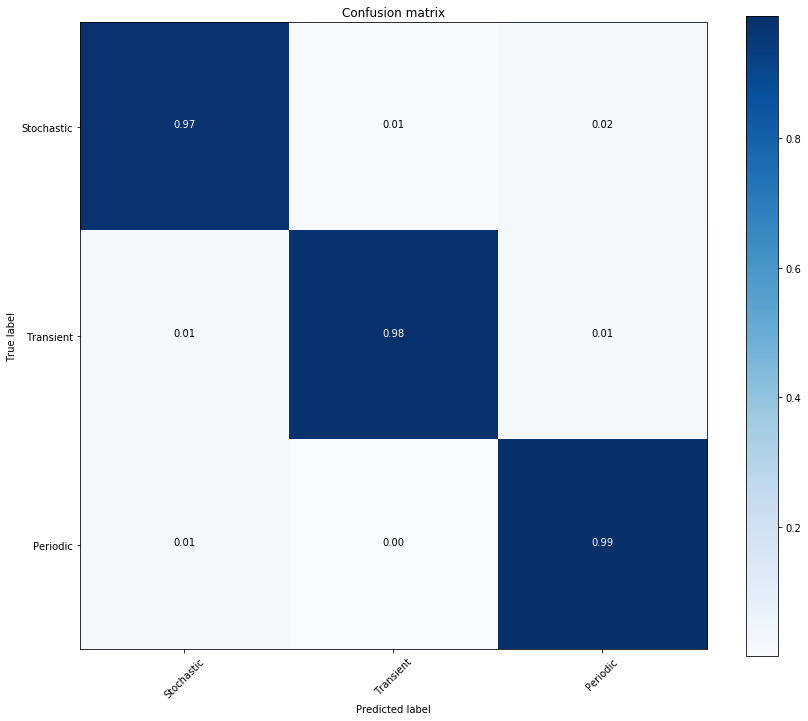

In [11]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(le_hierarchical.inverse_transform(y_true), le_hierarchical.inverse_transform(y_pred), labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,conf_matrix_name_first_layer)

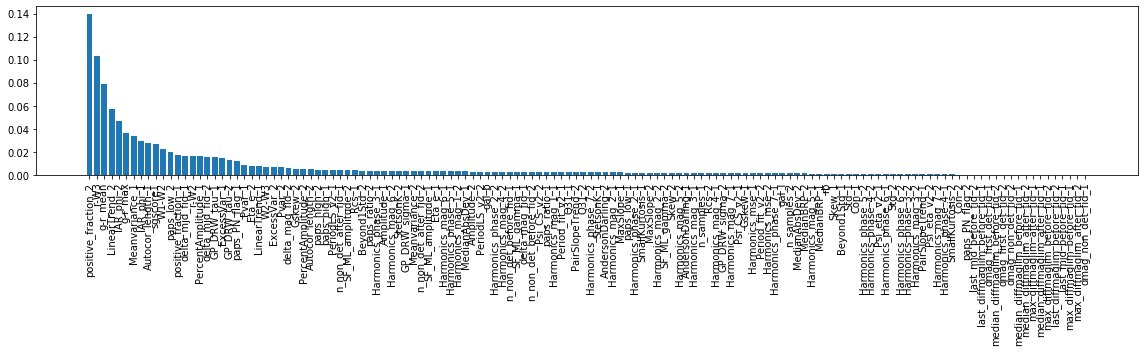

In [12]:
#plotting feature importance
plot_feature_importances(exgb_hierarchical, features_hierarchical, feature_importance_name_first_layer)

  ### Periodic layer

In [13]:
'''
class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train_periodic_encoded), y_train_periodic_encoded))
print(class_weights)
w_array = np.ones(len(y_train_periodic_encoded), dtype = 'float')

for i in range(len(class_weights)):
    w_array[np.where(y_train_periodic_encoded.astype(int)==i)]=class_weights[i]


print(w_array)
print(len(w_array))
'''

"\nclass_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train_periodic_encoded), y_train_periodic_encoded))\nprint(class_weights)\nw_array = np.ones(len(y_train_periodic_encoded), dtype = 'float')\n\nfor i in range(len(class_weights)):\n    w_array[np.where(y_train_periodic_encoded.astype(int)==i)]=class_weights[i]\n\n\nprint(w_array)\nprint(len(w_array))\n"

In [14]:
#Training Periodic layer

exgb_periodic = XGBClassifier(
   max_depth=7,
   min_child_weight=1,
   learning_rate=0.1,
   n_estimators=500,
   silent=False,
   objective='multi:softmax',
   gamma=0,
   max_delta_step=0,
   subsample=0.7,
   colsample_bytree=0.7,
   reg_alpha=0,
   reg_lambda=0,
   scale_pos_weight=1,
   missing=-999,
   n_jobs=5,
)

ros = RandomUnderSampler(sampling_strategy='all')
N_samplers=1
out_sampler_X = []
out_sampler_Y = []

for i in range(N_samplers):
    X_resampled, y_resampled = ros.fit_resample(X_train_periodic, y_train_periodic_encoded)
    X_resampled_df = pd.DataFrame(X_resampled,columns=X_train_hierarchical.columns)
    out_sampler_X.append(X_resampled_df)
    out_sampler_Y.append(y_resampled)
    
df_final_X = pd.concat(out_sampler_X)
y_resampled_final=np.array(out_sampler_Y).flatten()
print(y_resampled_final)    
print(sorted(Counter(y_resampled_final).items()))

#exgb_periodic.fit(X_train_periodic, y_train_periodic_encoded, sample_weight=w_array_periodic)
exgb_periodic.fit(df_final_X, y_resampled_final)



# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = le_original.transform(y_test_original), exgb_periodic.predict(X_test_periodic)
y_pred_proba_periodic = exgb_periodic.predict_proba(X_test_periodic)


[ 3  3  3 ... 11 11 11]
[(3, 198), (4, 198), (5, 198), (6, 198), (8, 198), (10, 198), (11, 198)]


In [15]:
classes_order_proba_periodic = exgb_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': exgb_periodic,
            'features': features_periodic,
            'order_classes': classes_order_proba_periodic
            }
        pickle.dump(model_dump, pickle_file)

[ 3  4  5  6  8 10 11]


82


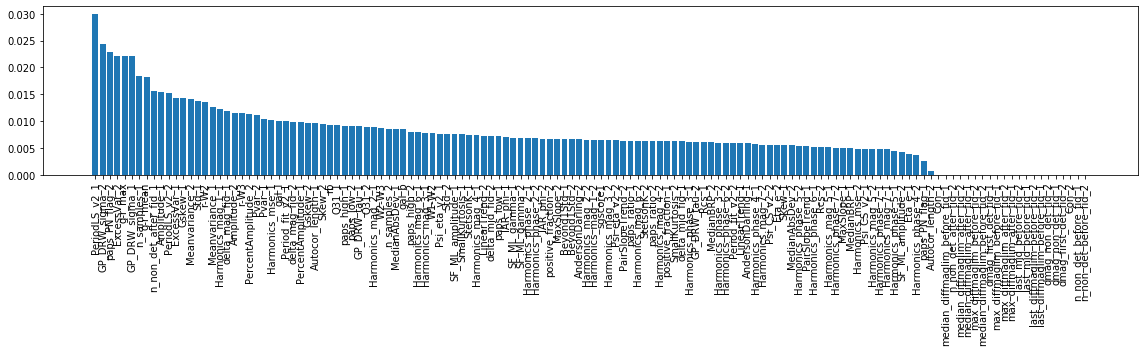

In [16]:
#plotting feature importance
print(len(feature_importance_name_first_layer))
plot_feature_importances(exgb_periodic, features_periodic, feature_importance_name_periodic_layer)

  ### Stochastic layer

In [17]:
'''class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train_stochastic_encoded), y_train_stochastic_encoded))
print(class_weights)
w_array = np.ones(len(y_train_stochastic_encoded), dtype = 'float')

for i in range(len(class_weights)):
    w_array[np.where(y_train_stochastic_encoded.astype(int)==i)]=class_weights[i]


print(w_array)
print(len(w_array))'''

"class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train_stochastic_encoded), y_train_stochastic_encoded))\nprint(class_weights)\nw_array = np.ones(len(y_train_stochastic_encoded), dtype = 'float')\n\nfor i in range(len(class_weights)):\n    w_array[np.where(y_train_stochastic_encoded.astype(int)==i)]=class_weights[i]\n\n\nprint(w_array)\nprint(len(w_array))"

In [18]:
#Training Stochastic layer

exgb_stochastic = XGBClassifier(
   max_depth=7,
   min_child_weight=1,
   learning_rate=0.1,
   n_estimators=500,
   silent=False,
   objective='multi:softmax',
   gamma=0,
   max_delta_step=0,
   subsample=0.7,
   colsample_bytree=0.7,
   reg_alpha=0,
   reg_lambda=0,
   scale_pos_weight=1,
   missing=-999,
   n_jobs=5,
)


ros = RandomUnderSampler(sampling_strategy='all')
N_samplers=1
out_sampler_X = []
out_sampler_Y = []

for i in range(N_samplers):
    X_resampled, y_resampled = ros.fit_resample(X_train_stochastic, y_train_stochastic_encoded)
    X_resampled_df = pd.DataFrame(X_resampled,columns=X_train_hierarchical.columns)
    out_sampler_X.append(X_resampled_df)
    out_sampler_Y.append(y_resampled)
    
df_final_X = pd.concat(out_sampler_X)
y_resampled_final=np.array(out_sampler_Y).flatten()
print(y_resampled_final)    
print(sorted(Counter(y_resampled_final).items()))


#exgb_stochastic.fit(X_train_stochastic, y_train_stochastic_encoded, sample_weight=w_array_stochastic)
exgb_stochastic.fit(df_final_X, y_resampled_final)


# Applying periodic model to the test data
y_true_stochastic, y_pred_stochastic = le_original.transform(y_test_original), exgb_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = exgb_stochastic.predict_proba(X_test_stochastic)

[ 0  0  0 ... 16 16 16]
[(0, 623), (1, 623), (2, 623), (7, 623), (9, 623), (16, 623)]


In [19]:
classes_order_proba_stochastic = exgb_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)

with open(model_stochastic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': exgb_stochastic,
            'features': features_stochastic,
            'order_classes': classes_order_proba_stochastic
            }
        pickle.dump(model_dump, pickle_file)

[ 0  1  2  7  9 16]


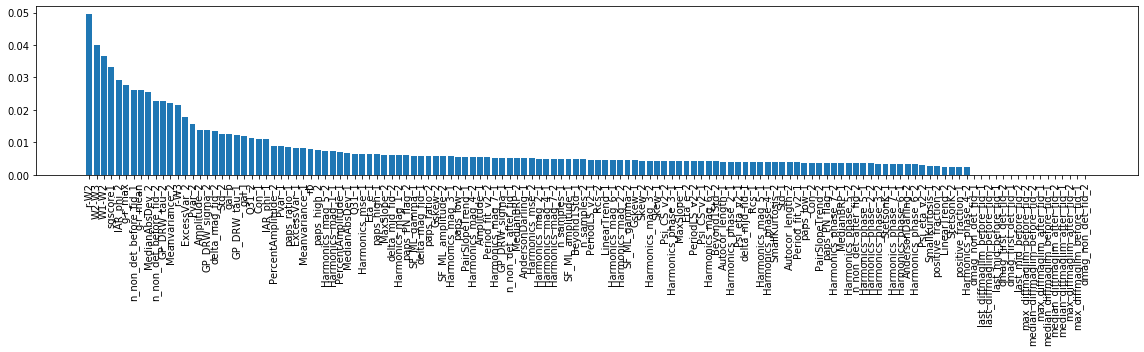

In [20]:
#plotting feature importance
plot_feature_importances(exgb_stochastic, features_stochastic, feature_importance_name_stochastic_layer)

  ### Transient layer

In [21]:
'''class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train_transient_encoded), y_train_transient_encoded))
print(class_weights)
w_array = np.ones(len(y_train_transient_encoded), dtype = 'float')

for i in range(len(class_weights)):
    w_array[np.where(y_train_transient_encoded.astype(int)==i)]=class_weights[i]


print(w_array)
print(len(w_array))'''

"class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train_transient_encoded), y_train_transient_encoded))\nprint(class_weights)\nw_array = np.ones(len(y_train_transient_encoded), dtype = 'float')\n\nfor i in range(len(class_weights)):\n    w_array[np.where(y_train_transient_encoded.astype(int)==i)]=class_weights[i]\n\n\nprint(w_array)\nprint(len(w_array))"

In [22]:
#Training Transient layer

exgb_transient = XGBClassifier(
   max_depth=7,
   min_child_weight=1,
   learning_rate=0.1,
   n_estimators=500,
   silent=False,
   objective='multi:softmax',
   gamma=0,
   max_delta_step=0,
   subsample=0.7,
   colsample_bytree=0.7,
   reg_alpha=0,
   reg_lambda=0,
   scale_pos_weight=1,
   missing=-999,
   n_jobs=5,
)

ros = RandomOverSampler(sampling_strategy='all')
N_samplers=1
out_sampler_X = []
out_sampler_Y = []

for i in range(N_samplers):
    X_resampled, y_resampled = ros.fit_resample(X_train_transient, y_train_transient_encoded)
    X_resampled_df = pd.DataFrame(X_resampled,columns=X_train_hierarchical.columns)
    out_sampler_X.append(X_resampled_df)
    out_sampler_Y.append(y_resampled)
    
df_final_X = pd.concat(out_sampler_X)
y_resampled_final=np.array(out_sampler_Y).flatten()
print(y_resampled_final)    
print(sorted(Counter(y_resampled_final).items()))



#exgb_transient.fit(X_train_transient, y_train_transient_encoded, sample_weight=w_array_transient)
exgb_transient.fit(df_final_X, y_resampled_final)




# Applying periodic model to the test data
y_true_transient, y_pred_transient = le_original.transform(y_test_original), exgb_transient.predict(X_test_transient)
y_pred_proba_transient = exgb_transient.predict_proba(X_test_transient)

[14 14 14 ... 15 15 15]
[(12, 530), (13, 530), (14, 530), (15, 530)]


In [23]:
classes_order_proba_transient = exgb_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_stochastic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': exgb_transient,
            'features': features_transient,
            'order_classes': classes_order_proba_transient
            }
        pickle.dump(model_dump, pickle_file)

[12 13 14 15]


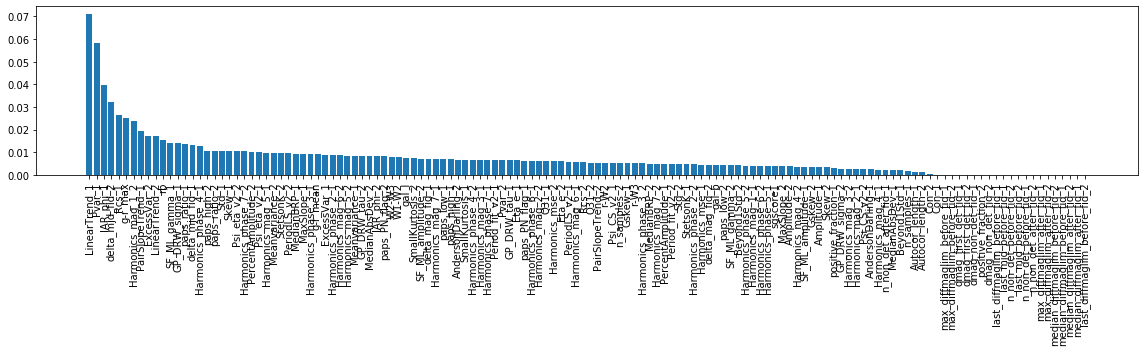

In [24]:
#plotting feature importance
plot_feature_importances(exgb_transient, features_transient, feature_importance_name_transient_layer)

 ## Putting al layers together  


In [25]:
# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(le_hierarchical.inverse_transform(classes_order_proba_hierarchical)=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(le_hierarchical.inverse_transform(classes_order_proba_hierarchical)=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(le_hierarchical.inverse_transform(classes_order_proba_hierarchical)=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]

print(class_final_proba)

[1.0000001  1.         0.99999994 ... 1.         1.0000001  1.        ] 1.0 6.775124e-08
[ 0  1  2  7  9 16 12 13 14 15  3  4  5  6  8 10 11]
[0.99940974 0.9997831  0.9997181  ... 0.64837784 0.70627254 0.41918984]


[[1508  187   91    3    3    0    0    5    0    0    1    0    3    0
     0    1    2]
 [  30  343   21    2    0    9    0   18    0    1    1    0    1    1
     0    0    2]
 [  27   16  133    1    2    1    0    1    0    0    0    0    0    0
     1    0    0]
 [   1    1    0   36    0   10    0    6    0    6    3   10   47    4
     2    4   26]
 [   0    0    0    1  190    0    0    0    0    0    3    0    1    2
     6   14    4]
 [   0    0    1    0    0  121    3    7    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    4    1    4    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    1   10    0   25    0    1    0    0    0    0
     0    0    1]
 [   0    0    0    0    0    3    0    1    0    0    0    0    0    0
     0    0    0]
 [   1    0    1    4   10    0    0    3    0 2210 1357  218  122  109
    20  467  517]
 [   0    0    0    3    0    0    0    0    0  256  749   63   46   40
     6   92   98]
 [   1    

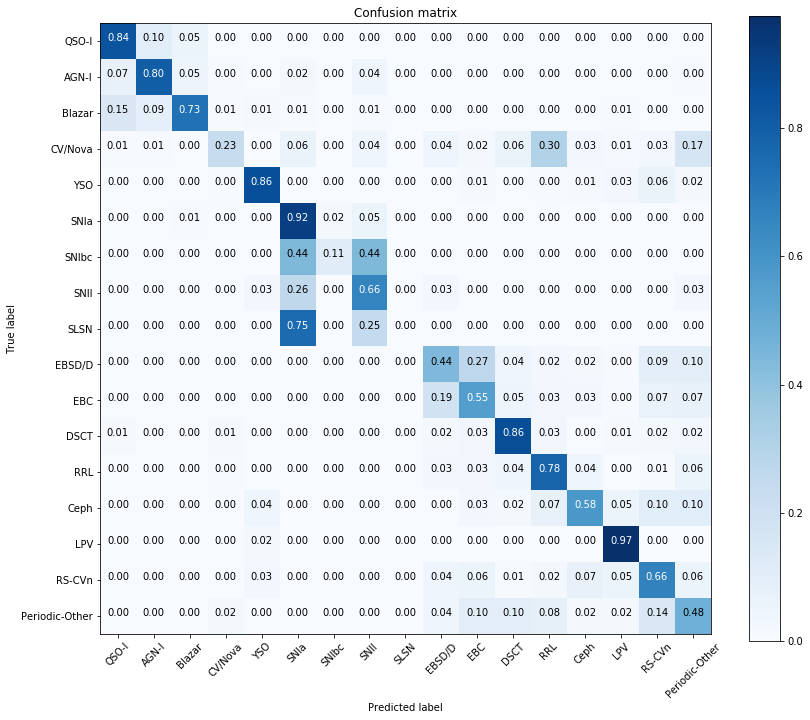

In [26]:
# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, le_original.inverse_transform(class_final_name),labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, conf_matrix_name_second_layer)

print("Accuracy:", metrics.accuracy_score(y_test_original, le_original.inverse_transform(class_final_name)))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, le_original.inverse_transform(class_final_name)))

In [27]:
# Kaggle score

num_y_test =  [np.where(le_original.inverse_transform(prob_final_class_names)==x)[0][0] for x in y_test_original] #label_encoder.transform(y_test)

class_weights = list(class_weight.compute_class_weight('balanced', label_order, y_test_original))

print(class_weights)

CLASSES_REDUCED_V2 = prob_final_class_names

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final,class_weights))

[0.726653188991783, 3.055669820375703, 7.202650290885585, 8.403092006033182, 5.931594357199893, 9.930926916221035, 145.65359477124184, 34.4969040247678, 327.72058823529414, 0.2601473214806859, 0.9688709186557106, 10.161878704970361, 0.22240962893470928, 11.398976982097187, 0.19928281437232845, 8.62422600619195, 26.21764705882353]
0 -0.48172310901361415
1 -3.051183542138867
2 -22.738344992987173
7 -0.727669561568361
9 -3.7783812024125654
16 -6.159467277865784
12 -804.030343146106
13 -42.2006500754563
14 -78.61243147183868
15 -1.2034071290434423
3 -1.5293556156119472
4 -4.97340786609267
5 -0.3112513019478524
6 -20.002492256786514
8 -0.4431193566715903
10 -6.7654308270743755
11 -36.76221550492679
1.7195836151612578


  ## Analysis post classification in training set

In [28]:
oids_test = y_test_original.copy()#.index.values
oids_test = oids_test.to_frame()
classified_names = np.array(class_final_name)

oids_test['pred_class'] = classified_names

print(oids_test.head())

LPV_asAGN = oids_test.loc[(oids_test.class_original=='AGN-I') & (oids_test.pred_class=='QSO-I')].index.values
#LPV_asAGN = y_test_original.loc[y_test_original.values=='QSO-I']


print(LPV_asAGN) 

print(df.loc[LPV_asAGN])
test_csv = df.loc[LPV_asAGN]
test_csv.to_csv('~/Desktop/blazar_class_as_QSO.csv')


             class_original  pred_class
oid                                    
ZTF18abmfocw         Blazar           1
ZTF17aaapvwl            LPV           7
ZTF18abcjbly            LPV           7
ZTF18abakohd            RRL          10
ZTF18abnkgmr            LPV           7
[]
Empty DataFrame
Columns: [n_samples_1, Amplitude_1, AndersonDarling_1, Autocor_length_1, Beyond1Std_1, Con_1, Eta_e_1, Gskew_1, MaxSlope_1, Meanvariance_1, MedianAbsDev_1, MedianBRP_1, PairSlopeTrend_1, PercentAmplitude_1, Q31_1, PeriodLS_v2_1, Period_fit_v2_1, Psi_CS_v2_1, Psi_eta_v2_1, Rcs_1, Skew_1, SmallKurtosis_1, Std_1, StetsonK_1, Harmonics_mag_1_1, Harmonics_mag_2_1, Harmonics_mag_3_1, Harmonics_mag_4_1, Harmonics_mag_5_1, Harmonics_mag_6_1, Harmonics_mag_7_1, Harmonics_phase_2_1, Harmonics_phase_3_1, Harmonics_phase_4_1, Harmonics_phase_5_1, Harmonics_phase_6_1, Harmonics_phase_7_1, Harmonics_mse_1, Pvar_1, ExcessVar_1, SF_ML_amplitude_1, SF_ML_gamma_1, GP_DRW_sigma_1, GP_DRW_tau_1, IAR_phi_1, Linea

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


  ## Classifying unlabeled data

In [29]:
#loading the data

print(df_feat.n_samples_1.size)
print(rm_nd_cols)

#rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
#             'Mean_1','Mean_2','paps_non_zero_1','paps_non_zero_2']

'''rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'Mean_1',
'Mean_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
]'''

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
#df_feat_ul = df_feat_ul.join(df_wise.drop(wise_drop, axis=1))
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

print(df_feat_ul.n_samples_1.size)

if extragalactic:
    df_feat_ul = df_feat_ul[(df_feat_ul.gal_b > 20) | (df_feat_ul.gal_b < -20)]

if galactic:
    df_feat_ul = df_feat_ul[(df_feat_ul.gal_b <= 20) & (df_feat_ul.gal_b >= -20)]
    
if morethan5:
    df_feat_ul = df_feat_ul[(df_feat_ul.n_samples_1 > 5) & (df_feat_ul.n_samples_2 > 5)]
    
df_feat_ul_out = df_feat_ul
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

df_feat_ul.head()

653905
['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'paps_non_zero_1', 'paps_non_zero_2', 'W1', 'W2', 'W3', 'W4', 'u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z']
653905


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaal,5.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-1.493229,1.000000,0.500000,0.626905,1.000000,-0.089,0.912,2.997933,2.085933
ZTF17aaaaaam,0.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,0.083333,0.635476,0.987167,0.038,0.565,5.909550,5.344550
ZTF17aaaaaan,57.0,0.259178,1.0,1.0,0.385965,0.0,2.666081,-0.081434,0.488864,0.011620,...,7.003891,-2.943499,0.459016,0.172414,0.730000,1.000000,-0.160,0.893,3.745013,2.852013
ZTF17aaaaaao,32.0,0.238777,1.0,1.0,0.343750,0.0,0.651816,-0.104300,0.173520,0.007609,...,33.561080,-0.202701,0.156250,0.325581,0.776667,0.999167,0.014,1.623,4.135574,2.512574
ZTF17aaaaaas,77.0,0.383210,1.0,1.0,0.155844,0.0,1.490287,0.628897,0.875627,0.012610,...,1.285452,15.110684,0.844156,0.000000,0.838333,0.996667,0.006,1.001,4.327510,3.326510


In [30]:
#predicting classes of unlabeled data


test_Y_hierarchical = exgb_hierarchical.predict(df_feat_ul)
test_Y_proba_hierarchical = exgb_hierarchical.predict_proba(df_feat_ul)

test_Y_periodic = exgb_periodic.predict(df_feat_ul)
test_Y_proba_periodic = exgb_periodic.predict_proba(df_feat_ul)

test_Y_stochastic = exgb_stochastic.predict(df_feat_ul)
test_Y_proba_stochastic = exgb_stochastic.predict_proba(df_feat_ul)

test_Y_transient = exgb_transient.predict(df_feat_ul)
test_Y_proba_transient = exgb_transient.predict_proba(df_feat_ul)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(le_hierarchical.inverse_transform(classes_order_proba_hierarchical)=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(le_hierarchical.inverse_transform(classes_order_proba_hierarchical)=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(le_hierarchical.inverse_transform(classes_order_proba_hierarchical)=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]


[0.99999994 1.         1.         ... 1.         1.         1.        ] 1.0 6.6256945e-08
[ 0  1  2  7  9 16 12 13 14 15  3  4  5  6  8 10 11]


In [31]:
#Writing results in the output

df_out = df_feat_ul_out
print(df_out.shape)
print(class_final_name_ul)
print(len(prob_final_ul))

class_final_name_ul_final = le_original.inverse_transform(class_final_name_ul)

df_out['predicted_class'] = class_final_name_ul_final
df_out['predicted_class_proba'] = class_final_proba_ul
test_data_withclass = df_out

'''
probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()
'''

(653905, 136)
[11, 16, 5, 5, 3, 6, 11, 5, 3, 5, 4, 5, 5, 3, 6, 11, 10, 5, 5, 7, 6, 11, 6, 5, 5, 6, 6, 16, 6, 5, 5, 11, 5, 8, 5, 6, 16, 16, 7, 6, 3, 7, 6, 6, 11, 3, 7, 16, 5, 6, 16, 16, 6, 7, 6, 5, 4, 16, 5, 7, 6, 11, 11, 16, 5, 16, 16, 11, 6, 5, 3, 6, 6, 6, 5, 5, 4, 11, 5, 16, 5, 5, 6, 16, 16, 7, 5, 3, 7, 6, 6, 5, 6, 5, 5, 10, 5, 10, 5, 11, 3, 5, 5, 5, 4, 2, 11, 5, 16, 5, 8, 5, 16, 5, 16, 11, 16, 16, 5, 6, 5, 5, 5, 5, 3, 6, 6, 10, 7, 5, 6, 7, 11, 5, 7, 5, 5, 7, 11, 5, 11, 5, 5, 7, 5, 5, 5, 11, 7, 5, 5, 5, 11, 5, 11, 5, 7, 5, 11, 7, 6, 7, 6, 7, 5, 16, 7, 11, 16, 11, 3, 7, 5, 16, 8, 7, 7, 11, 16, 5, 11, 5, 7, 6, 11, 6, 16, 3, 16, 5, 5, 7, 16, 5, 7, 6, 5, 6, 5, 16, 6, 6, 10, 7, 13, 11, 11, 5, 7, 6, 11, 5, 11, 2, 6, 6, 5, 6, 16, 11, 7, 6, 10, 16, 5, 6, 16, 5, 11, 16, 16, 5, 5, 5, 6, 11, 6, 7, 6, 5, 6, 11, 5, 10, 6, 6, 8, 4, 5, 6, 6, 6, 8, 6, 5, 3, 6, 5, 7, 6, 6, 5, 6, 4, 11, 5, 6, 6, 10, 5, 16, 16, 5, 8, 16, 3, 5, 8, 16, 7, 6, 6, 6, 5, 6, 6, 10, 8, 5, 6, 11, 6, 5, 5, 6, 5, 5, 6, 6, 11, 6, 

"\nprobs_header = prob_final_class_names_ul + '_prob'\n\nprob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)\n\nprob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)\n\ntest_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)\n\ntest_data_withclass.to_csv(class_output)\n\ntest_data_withclass.head()\n"

In [32]:
test_data_withclass.shape
#class_final_name_ul = le_original.inverse_transform(class_final_name_ul)

(653905, 138)

Text(0.5, 1.0, 'sources classified')

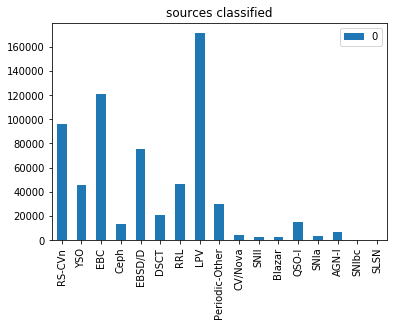

In [33]:
letter_counts = Counter(class_final_name_ul_final)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')


IndexError: cannot do a non-empty take from an empty axes.

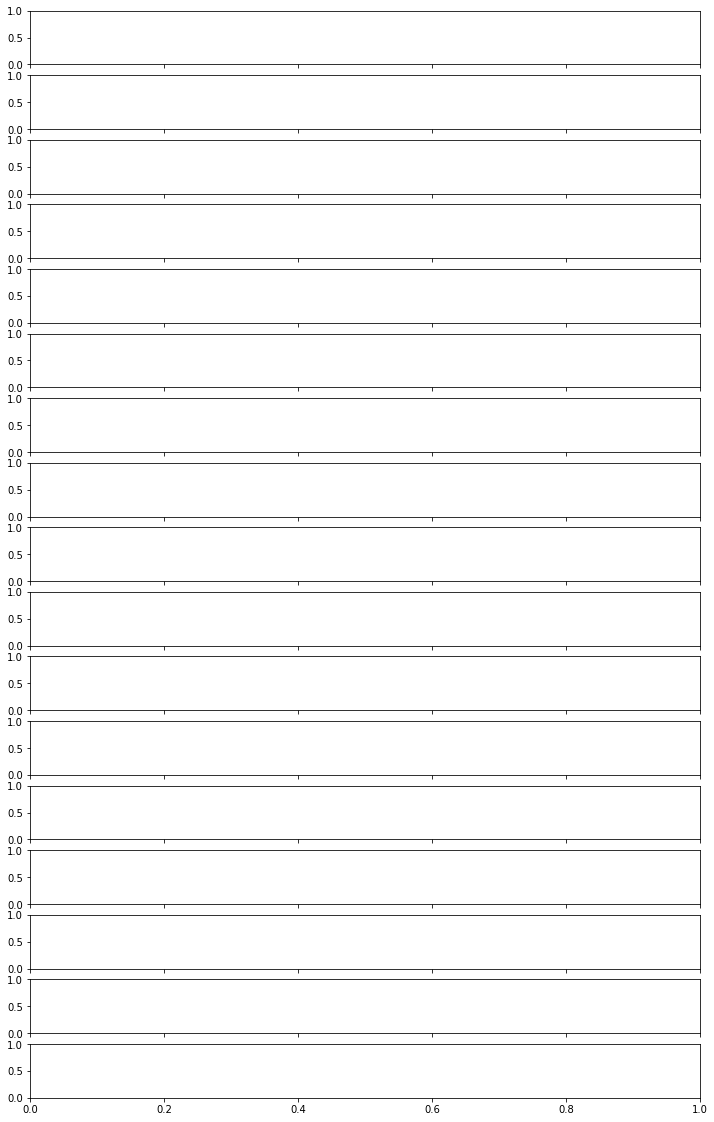

In [34]:

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(prob_final_class_names_ul):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

0 QSO-I 0.11459617685430068
1 AGN-I 0.1568970179563518
2 Blazar 0.3936305181058977
3 CV/Nova -0.025153739921998763
4 YSO 1.6561184274155991
5 SNIa 0.010153095444898952
6 SNIbc 0.42910861968995023
7 SNII 0.1709003448486488
8 SLSN 0.15327644348140268
9 EBSD/D 0.547338835339902
10 EBC 0.5682365305430022
11 DSCT 0.0373906900739982
12 RRL 0.0596858587444018
13 Ceph 0.7970160313865993
14 LPV 2.2658560465057516
15 RS-CVn 0.8990823419966016
16 Periodic-Other 0.4781691601197995


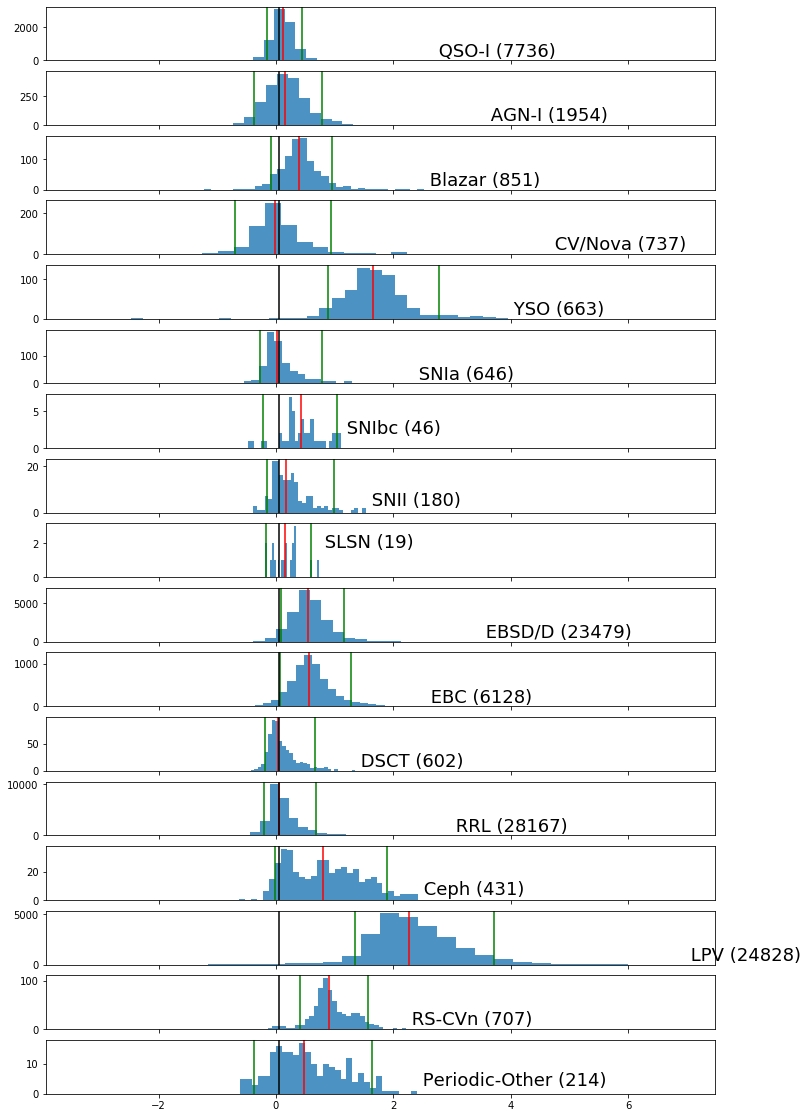

In [35]:
feature = 'g-r_max'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   if logscale: 
      feat = np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values)
      feat = feat[feat>0]
      ax[idx].hist(np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values), density=False, bins=30, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, density=False, bins=30, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train_plot[feature][df_train_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_train_plot[feature][df_train_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

QSO-I 12330
AGN-I 5073
Blazar 2602


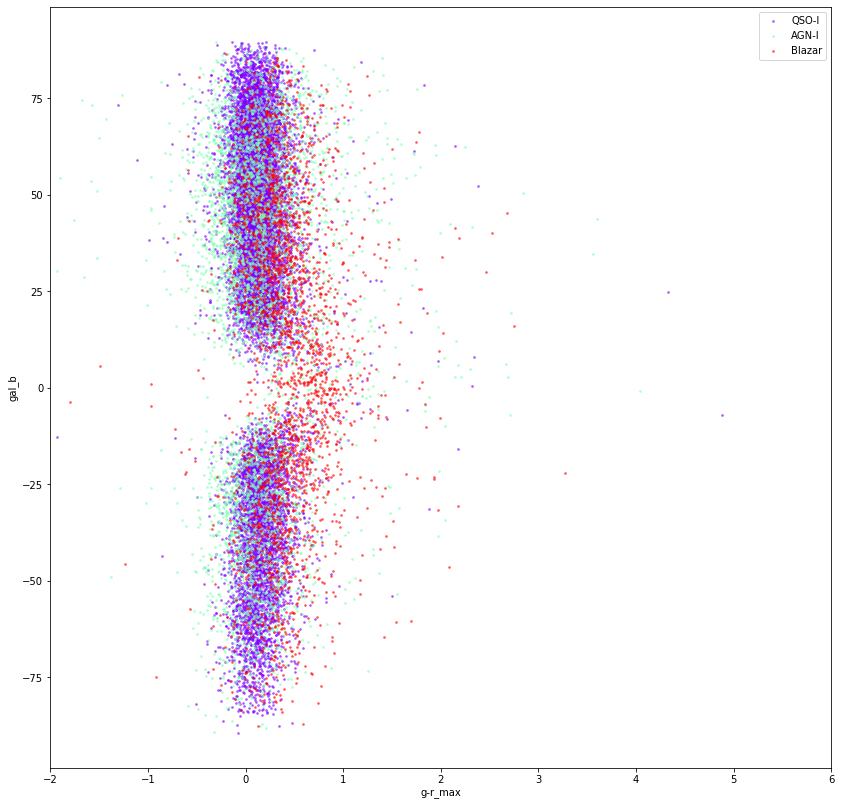

In [36]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
labels_list = ['QSO-I','AGN-I','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)

for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   print(cl,len(df_test[feature_x][df_test['predicted_class']==cl].values))
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.5, s = 3,label=cl)
   
plt.legend()
plt.xlabel('g-r_max')
plt.ylabel('gal_b')
plt.savefig('../feature_analysis_train_set/color_gal_b_selection.png')

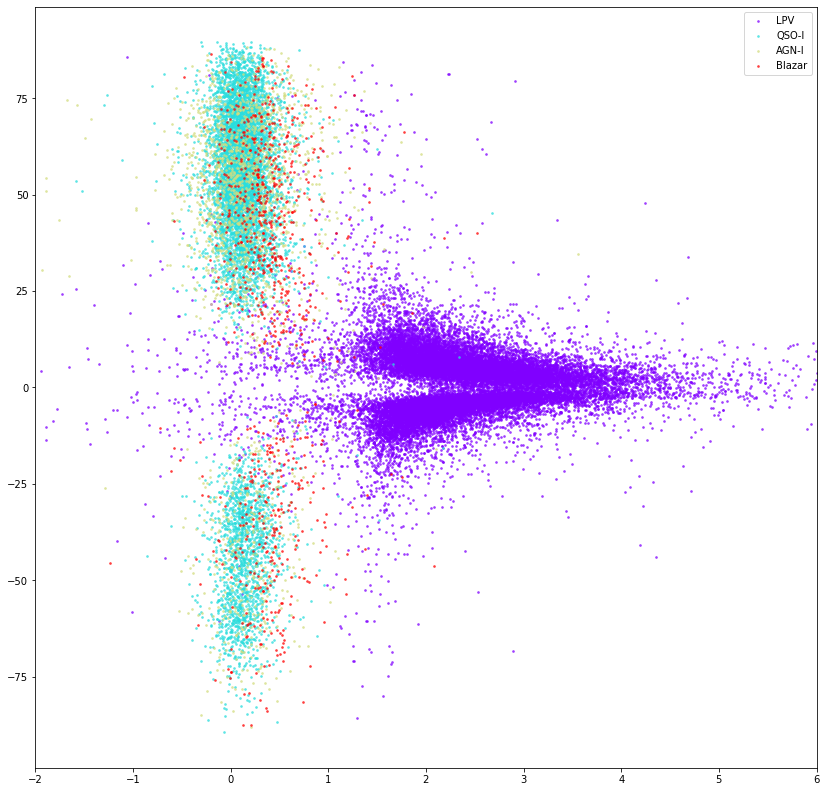

In [37]:
import matplotlib.cm as cm

feature_x = 'g-r_max'#'GP_DRW_sigma_1'
feature_y = 'gal_b' #'GP_DRW_tau_1'
labels_list = ['LPV','QSO-I','AGN-I','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
#ax.set_xlim(-4,3)
#ax.set_ylim(-4,5)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.6,s = 3,label=cl)
   #ax.scatter(np.log10(df_plot[feature_x][df_plot['class_original']==cl].values),np.log10(df_plot[feature_y][df_plot['class_original']==cl].values),color=colors[idx],alpha=0.6,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')